In [24]:
from Discriminamometro import Utileria, Discriminamometro
import pandas as pd
import spacy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier


nlp = spacy.load('./data/tweets/')
# Se instancia la clase del Discriminamometro
obj_Discr = Discriminamometro('PRUEBA')

# Mostramos la cantidad de tweets
print(obj_Discr.nbr_TweetsXCorrida)

8


In [25]:
data = pd.read_csv("data/Tuits Discriminatorios - jul2020 - Muestra Tuits.csv")

In [26]:
data.columns = ['full_text', 'categoria', 'disc', 'Observaciones']
data["disc"] = data["disc"].replace(['???'],'SI')

In [27]:
data["disc"].value_counts()

NO    631
SI    369
Name: disc, dtype: int64

In [28]:
data["disc"] = data["disc"].replace(['SI'],1)
data["disc"] = data["disc"].replace(['NO'],0)

In [29]:
data.head()

,full_text,categoria,disc,Observaciones
0,"!Viva la ""diversidad""! [?] \n\n!Proximamente e...",apariencia,0,capaz que la imagen es discriminatoria
1,@tennissucios @TenochHuerta Jajajaja... Muy ac...,apariencia,0,NaN
2,Hay momentos de la vida en los que te das cuen...,apariencia,0,NaN
3,@hornyboysmex @Hombres_sexgay Hermoso guerito !,apariencia,0,sextuiter es un mundo raro
4,Que restriccion tiene @DrGiammattei preparado ...,apariencia,0,NaN


In [30]:
obj_Discr.str_StopWords='StopWords.p'
obj_Discr.CargarStopWords()

data = obj_Discr.LimpiarDataFrame(data)
data = obj_Discr.QuitarStopWordsDataFrame(data)

In [31]:
train, test = train_test_split(data, test_size=0.2,random_state = 202008)

In [32]:
npEmbeddings = np.empty([0, 300])

for texto in train['full_text']:
    
    #print(texto)
    
    # process a sentence using the model
    doc = nlp(texto)
    
    # print(doc.vector.shape)
    if doc.vector.shape[0]==300:
        npEmbeddings = np.append(npEmbeddings, [doc.vector], axis = 0)
    else:
        npAux = np.empty([1, 300])
        npEmbeddings = np.append(npEmbeddings, npAux, axis = 0)

npEmbeddings.shape

(800, 300)

In [33]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import pandas as pd
import os

In [34]:
def Correr_Magic_Loop( npClassifier, npDictHyperParams, X_train, Y_train, nbrCv, strScoring):

        npResultados = np.array([])
        for i, classifier in enumerate(npClassifier):
            dictHyperParams = npDictHyperParams[i]
            grid_search = GridSearchCV(classifier,
                                       dictHyperParams,
                                       scoring=strScoring,
                                       cv=nbrCv,
                                       n_jobs=-1,
                                       verbose=3
                                       )
            grid_search.fit(X_train, Y_train)
            npResultados = np.append(npResultados, grid_search)

            # de los valores posibles que pusimos en el grid, cuáles fueron los mejores
            print('grid_search.best_params_: ', grid_search.best_params_)

            # mejor score asociado a los modelos generados con los diferentes hiperparametros
            # corresponde al promedio de los scores generados con los cv
            print('grid_search.best_score_: ', grid_search.best_score_)

            best_model = grid_search.best_estimator_


        return best_model, npResultados

In [35]:
def Prep_Modelos(npModelos):

    npArrayModelos = np.array([])
    for strModelo in npModelos:

        if strModelo == 'DECTREE':
            classifier = tree.DecisionTreeClassifier()
        if strModelo == 'RANDOMF':
            classifier = RandomForestClassifier()
        if strModelo == 'XGBOOST':
            classifier = GradientBoostingClassifier()

        npArrayModelos = np.append(npArrayModelos, classifier)

    return npArrayModelos

In [36]:
npDictHiperParam = np.array([]) 
# Parametrización para Árboles
dictHyperParams = {'max_depth': [4,7],  # 
                   'min_samples_split': [4,16],  # 
                   'min_samples_leaf': [3,7],  # 
                   'max_features': ['sqrt','log2']  # 
                   }
npDictHiperParam = np.append(npDictHiperParam, dictHyperParams)

# Parametrización para Bosques
dictHyperParams = {'n_estimators': [50],  # Se redujo a 50
                   'max_depth': [4,7],  # 
                   'max_features': ['sqrt','log2'],
                   'min_samples_split': [4,16],
                   'min_samples_leaf': [3,7]
                   }
npDictHiperParam = np.append(npDictHiperParam, dictHyperParams)

# Parametrización para XGBoost
dictHyperParams = {'learning_rate': [0.1,0.25, 0.75],
                   'n_estimators': [50,100,150],  # Se redujo a 50
                   'min_samples_split': [4,16],
                   'min_samples_leaf': [3,7],
                   'max_depth': [3,4,5,6,7,10,15],
                   'max_features': ['sqrt','log2']
                   }
npDictHiperParam = np.append(npDictHiperParam, dictHyperParams)

# Se crean los modelos de clasificaión que se emplearán (en el mismo orden que los diccionarios)
npNombreModelos = np.array([])
npNombreModelos = np.append(npNombreModelos, 'DECTREE')
npNombreModelos = np.append(npNombreModelos, 'RANDOMF')
npNombreModelos = np.append(npNombreModelos, 'XGBOOST')

In [37]:
X_train = pd.DataFrame(npEmbeddings)
Y_train = pd.DataFrame(train.disc)
arrModelos = Prep_Modelos(npNombreModelos)

# #Se corre el magic loop para realizar las predicciones con los parámetros previamente establecidos
best_model,npGridSearchCv = Correr_Magic_Loop(arrModelos,
                                    npDictHiperParam,
                                    X_train,
                                    Y_train,
                                    5,
                                    'roc_auc')

npArrBestScores = np.array([])
npArrBestParams = np.array([])

# Barremos el arreglo de GridSearchCV´s para sacar los mejores scores y parámetros
for grid in npGridSearchCv:
    npArrBestScores = np.append(npArrBestScores, grid.best_score_)
    npArrBestParams = np.append(npArrBestParams, grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


grid_search.best_params_:  {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 16}
grid_search.best_score_:  0.7520890895085314
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.5s finished
/home/francisco/anaconda3/envs/discriminamometro/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


grid_search.best_params_:  {'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 16, 'n_estimators': 50}
grid_search.best_score_:  0.8454783708508027
Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:  3.1min finished
/home/francisco/anaconda3/envs/discriminamometro/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


grid_search.best_params_:  {'learning_rate': 0.25, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 150}
grid_search.best_score_:  0.8761027603430745


In [38]:
# Obtenemos el índice del mejor score
nbrIndiceGanador = np.argmax(npArrBestScores, axis=0)

# Mostramos el modelo, parámetros y score ganador
# print("Modelo ganador: \n", arrModelos[nbrIndiceGanador])
# print("Score del modelo ganador: \n", npArrBestScores[nbrIndiceGanador])
# print("Parametros del modelo ganador: \n", npArrBestParams[nbrIndiceGanador])

# Se instancia el modelo ganador
# self.ModeloGanadorMagicLoop = objEda.InstanciarModeloDinamico(npNombreModelos, nbrIndiceGanador, npArrBestParams[nbrIndiceGanador])
ModeloGanadorMagicLoop = best_model

In [39]:
ModeloGanadorMagicLoop

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.25, loss='deviance', max_depth=15,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=4,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Desempeño en test

In [40]:
npEmbeddings2 = np.empty([0, 300])
for texto in test['full_text']:
    
    #print(frase)
    
    # process a sentence using the model
    doc = nlp(texto)
    
    # print(doc.vector.shape)
    #print(npEmbeddings.shape)
    #print(doc.vector.shape)
    
    if doc.vector.shape[0]==300:
        npEmbeddings2 = np.append(npEmbeddings2, [doc.vector], axis = 0)
    else:
        npAux = np.empty([1, 300])
        doc = nlp('prueba')
        #npEmbeddings = np.append(npEmbeddings, npAux, axis = 0)
        npEmbeddings2 = np.append(npEmbeddings2, [doc.vector], axis = 0)
        predicted_svm = clf.predict([doc.vector])
        
npEmbeddings2.shape

(200, 300)

In [52]:
import pickle as pickle

pickleFile = open('modelo_clasificacion_binaria_2.p', 'wb')
pickle.dump(best_model, pickleFile)
pickleFile.close()

In [16]:

################### Carga de parámetros
import pickle as pickle

pickleFile = open('modelo_clasificacion_binaria.p', 'rb')
best_model = pickle.load(pickleFile)
pickleFile.close()

In [41]:
predicted_svm = best_model.predict(npEmbeddings2)
np.mean(predicted_svm == test.disc)

0.76

In [51]:
tweet = 'pinche'
npAux = nlp(tweet).vector
predicted_svm = best_model.predict([npAux])
if(predicted_svm==0):
    print('No discriminación')
else:
    print('Si discrimina')

Si discrimina


In [43]:
y_probas = best_model.predict_proba(npEmbeddings2)
y_true = test.disc
y_prob = pd.DataFrame(y_probas)
y_prob.columns = ["cero","uno"]
y_prob = y_prob["uno"]

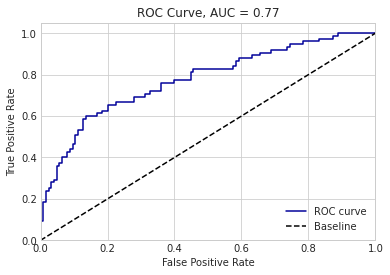

In [44]:
from sklearn import metrics
from matplotlib import pyplot as plt 

#Definimos la funcion que graficará la ROC
def plot_ROC(test_labels, test_predictions):
    fpr, tpr, thresholds = metrics.roc_curve(test_labels, 
                                             test_predictions, pos_label=1)
    auc = "%.2f" % metrics.auc(fpr, tpr)
    title = 'ROC Curve, AUC = '+str(auc)
    with plt.style.context(('seaborn-whitegrid')):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "#000099", label='ROC curve')
        ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.title(title)
    return  
plot_ROC(y_true, y_prob) 

# Prueba de categorías

In [120]:
data = pd.read_csv("tweets_julio_embeddings.csv")
data

/home/francisco/anaconda3/envs/discriminamometro/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,full_text,categoria
0,0,"!Viva la ""diversidad""! [?] \n\n!Proximamente e...",apariencia
1,1,@tennissucios @TenochHuerta Jajajaja... Muy ac...,apariencia
2,3,Hay momentos de la vida en los que te das cue...,apariencia
3,4,@hornyboysmex @Hombres_sexgay Hermoso guerito !,apariencia
4,5,Que restriccion tiene @DrGiammattei preparado ...,apariencia
...,...,...,...
3160328,360,@tamairycabrera Esa fue tu cara. https://t.co/...,neutro
3160329,361,no me voy a cansar de felicitar a todos los qu...,neutro
3160330,362,@CESARRRASCON Se mueren porque se encuentre al...,neutro
3160331,363,Las ganas son grandes bruh,neutro


In [121]:
class_names = ['1-ap','2-dis','3-ed', '4-gen',
               '5-id', '6-or', '7-rel', '8-neu']

data["categoria"] = data["categoria"].replace(['apariencia'],'1-ap')
data["categoria"] = data["categoria"].replace(['discapacidad'],'2-dis')
data["categoria"] = data["categoria"].replace(['edad'],'3-ed')
data["categoria"] = data["categoria"].replace(['genero'],'4-gen')
data["categoria"] = data["categoria"].replace(['ideologia'],'5-id')
data["categoria"] = data["categoria"].replace(['orientacion'],'6-or')
data["categoria"] = data["categoria"].replace(['religion'],'7-rel')
data["categoria"] = data["categoria"].replace(['neutro'],'8-neu')
data

,Unnamed: 0,full_text,categoria
0,0,"!Viva la ""diversidad""! [?] \n\n!Proximamente e...",1-ap
1,1,@tennissucios @TenochHuerta Jajajaja... Muy ac...,1-ap
2,3,Hay momentos de la vida en los que te das cue...,1-ap
3,4,@hornyboysmex @Hombres_sexgay Hermoso guerito !,1-ap
4,5,Que restriccion tiene @DrGiammattei preparado ...,1-ap
...,...,...,...
3160328,360,@tamairycabrera Esa fue tu cara. https://t.co/...,8-neu
3160329,361,no me voy a cansar de felicitar a todos los qu...,8-neu
3160330,362,@CESARRRASCON Se mueren porque se encuentre al...,8-neu
3160331,363,Las ganas son grandes bruh,8-neu


In [123]:
data['categoria'].value_counts()

8-neu    714821
4-gen    170274
6-or      85207
5-id      28998
1-ap      26987
2-dis     19956
3-ed       5583
7-rel      1772
Name: categoria, dtype: int64

In [102]:
data = data[data["categoria"].isnull()==False]
data

,Unnamed: 0,full_text,categoria
0,0,"!Viva la ""diversidad""! [?] \n\n!Proximamente e...",1-ap
1,1,@tennissucios @TenochHuerta Jajajaja... Muy ac...,1-ap
2,3,Hay momentos de la vida en los que te das cue...,1-ap
3,4,@hornyboysmex @Hombres_sexgay Hermoso guerito !,1-ap
4,5,Que restriccion tiene @DrGiammattei preparado ...,1-ap
...,...,...,...
3160328,360,@tamairycabrera Esa fue tu cara. https://t.co/...,8-neu
3160329,361,no me voy a cansar de felicitar a todos los qu...,8-neu
3160330,362,@CESARRRASCON Se mueren porque se encuentre al...,8-neu
3160331,363,Las ganas son grandes bruh,8-neu


In [103]:
data = data[data["categoria"]!='8-neu']
data

,Unnamed: 0,full_text,categoria
0,0,"!Viva la ""diversidad""! [?] \n\n!Proximamente e...",1-ap
1,1,@tennissucios @TenochHuerta Jajajaja... Muy ac...,1-ap
2,3,Hay momentos de la vida en los que te das cue...,1-ap
3,4,@hornyboysmex @Hombres_sexgay Hermoso guerito !,1-ap
4,5,Que restriccion tiene @DrGiammattei preparado ...,1-ap
...,...,...,...
338772,0,@reinatorres7 Exactamente es el derecho de la ...,7-rel
338773,1,Esta gente mojigata del fandom BL que se queja...,7-rel
338774,0,"Me dice un amigo, no si vos sos famosa, influe...",7-rel
338775,0,@Fernand12373883 Es su karma por burlarse de n...,7-rel


In [104]:
from sklearn.utils import shuffle
data = shuffle(data)
data

,Unnamed: 0,full_text,categoria
10193,5,Vida para ser eterna jodido https://t.co/9Jqp...,1-ap
293914,25,ojo que dijo P O R D E S G R A C I A \nque put...,6-or
28481,83,Tengo un amigo que siempre me dice que no cojo...,2-dis
298565,20,Cuando me peso y perdi % de musculo por no com...,6-or
89727,133,@ChinaBarraza @VicGarciaDice Puta si eso es ci...,4-gen
...,...,...,...
114263,27,@AztecaNoticiaGT Todos invitados a la mierda e...,4-gen
289456,17,"Nmms ya deja trabajar en paz, puto castroso",6-or
59978,57,Puta pila no me esta durando nada,4-gen
267819,60,@ramon51878697 @LOVREGA Creo que un joto te co...,6-or


In [105]:
data = data.iloc[0:1000]
data

,Unnamed: 0,full_text,categoria
10193,5,Vida para ser eterna jodido https://t.co/9Jqp...,1-ap
293914,25,ojo que dijo P O R D E S G R A C I A \nque put...,6-or
28481,83,Tengo un amigo que siempre me dice que no cojo...,2-dis
298565,20,Cuando me peso y perdi % de musculo por no com...,6-or
89727,133,@ChinaBarraza @VicGarciaDice Puta si eso es ci...,4-gen
...,...,...,...
14072,11,@jesusarroyo39 @roberta_diazv @Fernilalanina E...,1-ap
167641,61,Ofrecele cafe a tu puta madre pinche anciano.,4-gen
57677,150,Maxi es una puta mentira,4-gen
319842,175,Que pinche necesidad del vecino de prender su ...,6-or


In [106]:
obj_Discr.str_StopWords='StopWords.p'
obj_Discr.CargarStopWords()

data = obj_Discr.LimpiarDataFrame(data)
data = obj_Discr.QuitarStopWordsDataFrame(data)

In [107]:
data["categoria"].value_counts()

4-gen    473
6-or     259
5-id      93
1-ap      83
2-dis     68
3-ed      19
7-rel      5
Name: categoria, dtype: int64

In [108]:
train, test = train_test_split(data, test_size=0.2)
print(train.shape)
print(test.shape)
test.categoria.unique()

(800, 3)
(200, 3)


array(['6-or', '4-gen', '3-ed', '2-dis', '1-ap', '5-id', '7-rel'],
      dtype=object)

In [109]:
npEmbeddings = np.empty([0, 300])

for texto in train['full_text']:
    
    #print(texto)
    
    # process a sentence using the model
    doc = nlp(texto)
    
    # print(doc.vector.shape)
    if doc.vector.shape[0]==300:
        npEmbeddings = np.append(npEmbeddings, [doc.vector], axis = 0)
    else:
        npAux = np.empty([1, 300])
        npEmbeddings = np.append(npEmbeddings, npAux, axis = 0)

npEmbeddings.shape

(800, 300)

In [110]:
X_train = pd.DataFrame(npEmbeddings)
Y_train = pd.DataFrame(train.categoria)
arrModelos = Prep_Modelos(npNombreModelos)

# #Se corre el magic loop para realizar las predicciones con los parámetros previamente establecidos
best_model,npGridSearchCv = Correr_Magic_Loop(arrModelos,
                                    npDictHiperParam,
                                    X_train,
                                    Y_train,
                                    2,
                                    'accuracy')

npArrBestScores = np.array([])
npArrBestParams = np.array([])

# Barremos el arreglo de GridSearchCV´s para sacar los mejores scores y parámetros
for grid in npGridSearchCv:
    npArrBestScores = np.append(npArrBestScores, grid.best_score_)
    npArrBestParams = np.append(npArrBestParams, grid.best_params_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  20 out of  32 | elapsed:    1.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


grid_search.best_params_:  {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 4}
grid_search.best_score_:  0.5925
Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  32 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    1.0s finished
/home/francisco/anaconda3/envs/discriminamometro/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


grid_search.best_params_:  {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 50}
grid_search.best_score_:  0.7537499999999999
Fitting 2 folds for each of 504 candidates, totalling 1008 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1008 out of 1008 | elapsed:  4.0min finished
/home/francisco/anaconda3/envs/discriminamometro/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


grid_search.best_params_:  {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 16, 'n_estimators': 150}
grid_search.best_score_:  0.8225


In [111]:
# Obtenemos el índice del mejor score
nbrIndiceGanador = np.argmax(npArrBestScores, axis=0)

# Mostramos el modelo, parámetros y score ganador
# print("Modelo ganador: \n", arrModelos[nbrIndiceGanador])
# print("Score del modelo ganador: \n", npArrBestScores[nbrIndiceGanador])
# print("Parametros del modelo ganador: \n", npArrBestParams[nbrIndiceGanador])

# Se instancia el modelo ganador
# self.ModeloGanadorMagicLoop = objEda.InstanciarModeloDinamico(npNombreModelos, nbrIndiceGanador, npArrBestParams[nbrIndiceGanador])
ModeloGanadorMagicLoop = best_model
ModeloGanadorMagicLoop

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=7, min_samples_split=16,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# Test

In [112]:
npEmbeddings2 = np.empty([0, 300])
for texto in test['full_text']:
    
    #print(frase)
    
    # process a sentence using the model
    doc = nlp(texto)
    
    # print(doc.vector.shape)
    #print(npEmbeddings.shape)
    #print(doc.vector.shape)
    
    if doc.vector.shape[0]==300:
        npEmbeddings2 = np.append(npEmbeddings2, [doc.vector], axis = 0)
    else:
        npAux = np.empty([1, 300])
        doc = nlp('prueba')
        #npEmbeddings = np.append(npEmbeddings, npAux, axis = 0)
        npEmbeddings2 = np.append(npEmbeddings2, [doc.vector], axis = 0)
        predicted_svm = clf.predict([doc.vector])
        
npEmbeddings2.shape

(200, 300)

In [113]:
classifier = ModeloGanadorMagicLoop
X_test = npEmbeddings2 #pensé que era por eso el error jajaja ntp ahorita veoq ue show
y_test = test.categoria
class_names = ['1-ap','2-dis','3-ed', '4-gen',
               '5-id', '6-or', '7-rel']

In [114]:
print(X_test.shape)
print(y_test.shape)
test.categoria.unique()


(200, 300)
(200,)


array(['6-or', '4-gen', '3-ed', '2-dis', '1-ap', '5-id', '7-rel'],
      dtype=object)

Confusion matrix, without normalization
[[  8   0   0   2   0   6   0]
 [  1   8   0   4   1   1   0]
 [  0   0   0   2   0   0   0]
 [  1   0   0 106   0   0   0]
 [  0   0   0   2  12   3   0]
 [  0   0   0   0   1  41   0]
 [  0   0   0   1   0   0   0]]
Normalized confusion matrix
[[0.5        0.         0.         0.125      0.         0.375
  0.        ]
 [0.06666667 0.53333333 0.         0.26666667 0.06666667 0.06666667
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.00934579 0.         0.         0.99065421 0.         0.
  0.        ]
 [0.         0.         0.         0.11764706 0.70588235 0.17647059
  0.        ]
 [0.         0.         0.         0.         0.02380952 0.97619048
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]]


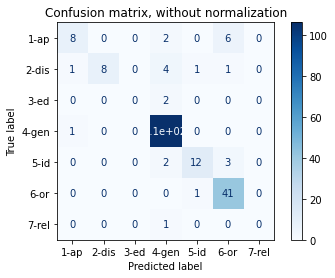

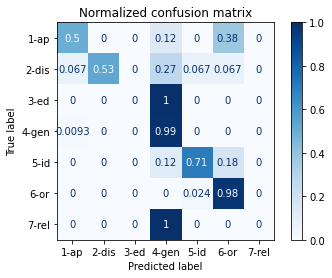

In [115]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [97]:
import pickle as pickle

pickleFile = open('modelo_multiclase_v1.p','wb')
pickle.dump(ModeloGanadorMagicLoop, pickleFile)
picklllleFile.close()


NameError: name 'picklllleFile' is not defined